In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

CREATING THE DATAFRAME OF PAIRS OF DIRECTORS AND ACTORS

In [2]:
movie_industry = pd.read_csv("../data/movie_industry.csv", encoding = "ISO-8859-1" )
movie_industry.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


In [3]:
class Graph:
    """ Wrapper class Graph to create a bipartite graph
    Takes in the following paramaters
    directors_to_actors_relation : Dataframe with the data for directors and actors
    weight func : function which defined the weight of an edge. Takes the dateframe to calcuate weights from and
    the nodes values to calculate for
    weight_func_args : column names used to calculate the weights
    director_column : Column name for director
    actor_column : Column name for actor, 
    bipartite : default true
    """
    def __init__(self, 
                 directors_to_actors_relation, 
                 weight_func, 
                 weight_func_args, 
                 director_column="director", 
                 actor_column="star", 
                 bipartite=True):
        self.G = nx.Graph()
        
        directors = set(directors_to_actors_relation[director_column].values)
        actors = set(directors_to_actors_relation[actor_column].values)
    
        #store the director node as a tuple with director name and boolean True to indicate director
        for director in directors:
            self.G.add_node((director, True))
            
        #store the actor node as a tuple with actor name and boolean False to indicate actor
        for actor in actors:
            self.G.add_node((actor, False))

        #add weights to all edges
        for director in directors:
            rows = directors_to_actors_relation[directors_to_actors_relation[director_column] == director]
            for index in rows.index.values:
                self.G.add_edge((director, True), 
                                (rows.loc[index, actor_column], False), 
                                weight=weight_func(*[rows.loc[index, i] for i in weight_func_args], directors_to_actors_relation))             

In [4]:
#calcualtes edge weight as the number of collaborations
#takes in director name, star name and data to calculate weight from
def example_weight_func(director, star, df):
    return len(df.loc[((df["director"] == director) & (df["star"] == star))])

In [5]:
storage = Graph(movie_industry, example_weight_func, ["director", "star"])

In [6]:
directors = list(set(movie_industry["director"].values))
actors = list(set(movie_industry["star"].values))

In [7]:
collabs = []
for director in directors:
    for actor in actors:
        if storage.G.get_edge_data((director, True), (actor, False)):
            collabs.append(storage.G.get_edge_data((director, True), (actor, False))["weight"])
        else:
            collabs.append(0)

In [8]:
res =  [director for director in directors for i in range(len(actors))] 
df = pd.DataFrame({"director": res, 
                   "actor": actors*len(directors),
                  "collabs": collabs})
df.head()

,director,actor,collabs
0,Joel Edgerton,Andrew Robinson,0
1,Joel Edgerton,Miles Teller,0
2,Joel Edgerton,Martin Landau,0
3,Joel Edgerton,Christopher McDonald,0
4,Joel Edgerton,Wagner Moura,0


In [9]:
df['collabs'].value_counts()

0     6902230
1        5929
2         299
3          52
4          13
5           5
6           4
11          1
10          1
8           1
7           1
Name: collabs, dtype: int64

ADDING AND TESTING COVARIATES

In [10]:
df["collab indicator"] = (df.collabs > 0)*1

In [11]:
def add_feature_actor(feature_total, feature_mean, feature_name):
    for actor in actors:
        temp = movie_industry[movie_industry.star ==  actor]
        sum_feature = sum(temp[feature_name].values)
        mean_feature = np.mean(temp[feature_name].values)
        feature_total[actor] = sum_feature
        feature_mean[actor] = mean_feature
        
def add_feature_director(feature_total, feature_mean, feature_name):
    for director in directors:
        temp = movie_industry[movie_industry.director ==  director]
        sum_feature = sum(temp[feature_name].values)
        mean_feature = np.mean(temp[feature_name].values)
        feature_total[director] = sum_feature
        feature_mean[director] = mean_feature

### budget

In [12]:
actor_total_budget = {}
actor_mean_budget = {}
add_feature_actor(actor_total_budget, actor_mean_budget, 'budget')
df["actor_total_budget"] = df.actor.map(actor_total_budget)
df["actor_mean_budget"] = df.actor.map(actor_mean_budget)

director_total_budget = {}
director_mean_budget = {}
add_feature_director(director_total_budget, director_mean_budget, 'budget')
df["director_total_budget"] = df.director.map(director_total_budget)
df["director_mean_budget"] = df.director.map(director_mean_budget)

df["total_budget_diff"] = abs(df.director_total_budget - df.actor_total_budget)
df["mean_budget_diff"] = abs(df.director_mean_budget - df.actor_mean_budget)
df.head()

,director,actor,collabs,collab indicator,actor_total_budget,actor_mean_budget,director_total_budget,director_mean_budget,total_budget_diff,mean_budget_diff
0,Joel Edgerton,Andrew Robinson,0,0,1000000.0,1.000000e+06,5000000.0,5000000.0,4000000.0,4.000000e+06
1,Joel Edgerton,Miles Teller,0,0,144800000.0,2.413333e+07,5000000.0,5000000.0,139800000.0,1.913333e+07
2,Joel Edgerton,Martin Landau,0,0,44000000.0,2.200000e+07,5000000.0,5000000.0,39000000.0,1.700000e+07
3,Joel Edgerton,Christopher McDonald,0,0,15000000.0,1.500000e+07,5000000.0,5000000.0,10000000.0,1.000000e+07
4,Joel Edgerton,Wagner Moura,0,0,4000000.0,2.000000e+06,5000000.0,5000000.0,1000000.0,3.000000e+06


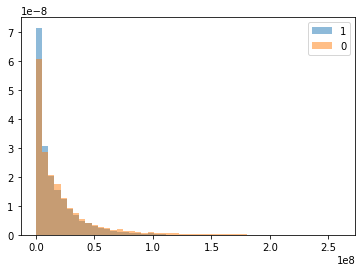

In [13]:
df_dropped = df.copy().dropna()
bins = np.linspace(min(df_dropped.mean_budget_diff.values), max(df_dropped.mean_budget_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].mean_budget_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].mean_budget_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()



In [15]:
from scipy.stats import ttest_ind
print('mean_budget_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].mean_budget_diff.values)))
print('mean_budget_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].mean_budget_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].mean_budget_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].mean_budget_diff.values, 
                      equal_var=False)

Ttest_indResult(statistic=-23.274224123640536, pvalue=4.8786376490310995e-115)

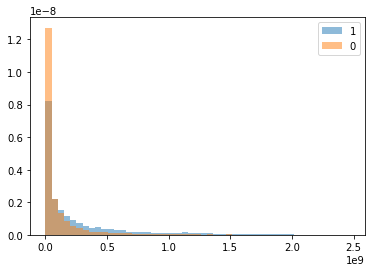

In [16]:
df_dropped = df.copy().dropna()
bins = np.linspace(min(df_dropped.total_budget_diff.values), max(df_dropped.total_budget_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].total_budget_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].total_budget_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [18]:
print('total_budget_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].total_budget_diff.values)))
print('total_budget_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].total_budget_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].total_budget_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].total_budget_diff.values, 
                      equal_var=False)

Ttest_indResult(statistic=30.707468124240446, pvalue=4.1316454624320973e-193)

### score

In [19]:
actor_total_score = {}
actor_mean_score = {}
add_feature_actor(actor_total_score, actor_mean_score, 'score')
df["actor_total_score"] = df.actor.map(actor_total_score)
df["actor_mean_score"] = df.actor.map(actor_mean_score)

director_total_score = {}
director_mean_score = {}
add_feature_director(director_total_score, director_mean_score, 'score')
df["director_total_score"] = df.director.map(director_total_score)
df["director_mean_score"] = df.director.map(director_mean_score)

df["total_score_diff"] = abs(df.director_total_score - df.actor_total_score)
df["mean_score_diff"] = abs(df.director_mean_score - df.actor_mean_score)
df.head()

,director,actor,collabs,collab indicator,actor_total_budget,actor_mean_budget,director_total_budget,director_mean_budget,total_budget_diff,mean_budget_diff,actor_total_score,actor_mean_score,director_total_score,director_mean_score,total_score_diff,mean_score_diff
0,Joel Edgerton,Andrew Robinson,0,0,1000000.0,1.000000e+06,5000000.0,5000000.0,4000000.0,4.000000e+06,7.0,7.00,7.1,7.1,0.1,0.10
1,Joel Edgerton,Miles Teller,0,0,144800000.0,2.413333e+07,5000000.0,5000000.0,139800000.0,1.913333e+07,39.0,6.50,7.1,7.1,31.9,0.60
2,Joel Edgerton,Martin Landau,0,0,44000000.0,2.200000e+07,5000000.0,5000000.0,39000000.0,1.700000e+07,13.3,6.65,7.1,7.1,6.2,0.45
3,Joel Edgerton,Christopher McDonald,0,0,15000000.0,1.500000e+07,5000000.0,5000000.0,10000000.0,1.000000e+07,5.1,5.10,7.1,7.1,2.0,2.00
4,Joel Edgerton,Wagner Moura,0,0,4000000.0,2.000000e+06,5000000.0,5000000.0,1000000.0,3.000000e+06,16.2,8.10,7.1,7.1,9.1,1.00


In [20]:
movie_industry[movie_industry.director=='Neal Brennan']

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
5254,0.0,Paramount Vantage,USA,Neal Brennan,Comedy,15102127.0,"The Goods: Live Hard, Sell Hard",R,2009-08-14,89,5.8,Jeremy Piven,18361,Andy Stock,2009


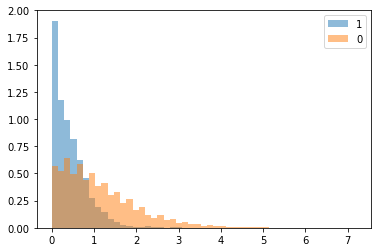

In [24]:
df_dropped = df.copy().dropna()
bins = np.linspace(min(df_dropped.mean_score_diff.values), max(df_dropped.mean_score_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].mean_score_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].mean_score_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()


In [31]:
print('mean_score_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].mean_score_diff.values)))
print('mean_score_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].mean_score_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].mean_score_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].mean_score_diff.values, 
                      equal_var=False)

mean_score_diff variance in pairs w/ collab is  0.1671648849403833
mean_score_diff variance in pairs w/o collab is  0.7926996535043865


Ttest_indResult(statistic=-132.73467425738679, pvalue=0.0)

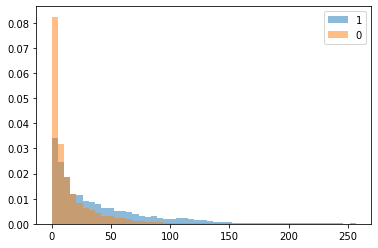

In [26]:
bins = np.linspace(min(df_dropped.total_score_diff.values), max(df_dropped.total_score_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].total_score_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].total_score_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()


In [28]:
print('total_score_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].total_score_diff.values)))
print('total_score_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].total_score_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].total_score_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].total_score_diff.values, 
                      equal_var=False)

total_score_diff variance in pairs w/ collab is  1951.7441230141521
total_score_diff variance in pairs w/o collab is  714.3838449451074


Ttest_indResult(statistic=40.1115485131673, pvalue=0.0)

### votes

In [29]:
actor_total_votes = {}
actor_mean_votes = {}
add_feature_actor(actor_total_votes, actor_mean_votes, 'votes')
df["actor_total_votes"] = df.actor.map(actor_total_votes)
df["actor_mean_votes"] = df.actor.map(actor_mean_votes)

director_total_votes = {}
director_mean_votes = {}
add_feature_director(director_total_votes, director_mean_votes, 'votes')
df["director_total_votes"] = df.director.map(director_total_votes)
df["director_mean_votes"] = df.director.map(director_mean_votes)

df["total_votes_diff"] = abs(df.director_total_votes - df.actor_total_votes)
df["mean_votes_diff"] = abs(df.director_mean_votes - df.actor_mean_votes)
df.head()

,director,actor,collabs,collab indicator,actor_total_budget,actor_mean_budget,director_total_budget,director_mean_budget,total_budget_diff,mean_budget_diff,...,director_total_score,director_mean_score,total_score_diff,mean_score_diff,actor_total_votes,actor_mean_votes,director_total_votes,director_mean_votes,total_votes_diff,mean_votes_diff
0,Joel Edgerton,Andrew Robinson,0,0,1000000.0,1.000000e+06,5000000.0,5000000.0,4000000.0,4.000000e+06,...,7.1,7.1,0.1,0.10,83209,83209.0,103554,103554.0,20345,20345.0
1,Joel Edgerton,Miles Teller,0,0,144800000.0,2.413333e+07,5000000.0,5000000.0,139800000.0,1.913333e+07,...,7.1,7.1,31.9,0.60,881853,146975.5,103554,103554.0,778299,43421.5
2,Joel Edgerton,Martin Landau,0,0,44000000.0,2.200000e+07,5000000.0,5000000.0,39000000.0,1.700000e+07,...,7.1,7.1,6.2,0.45,50677,25338.5,103554,103554.0,52877,78215.5
3,Joel Edgerton,Christopher McDonald,0,0,15000000.0,1.500000e+07,5000000.0,5000000.0,10000000.0,1.000000e+07,...,7.1,7.1,2.0,2.00,3396,3396.0,103554,103554.0,100158,100158.0
4,Joel Edgerton,Wagner Moura,0,0,4000000.0,2.000000e+06,5000000.0,5000000.0,1000000.0,3.000000e+06,...,7.1,7.1,9.1,1.00,157472,78736.0,103554,103554.0,53918,24818.0


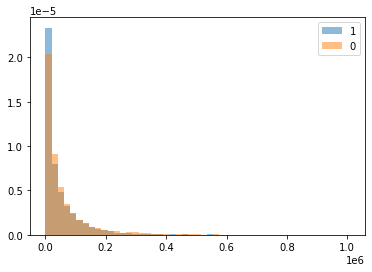

In [30]:
df_dropped = df.copy().dropna()
bins = np.linspace(min(df_dropped.mean_votes_diff.values), max(df_dropped.mean_votes_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].mean_votes_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].mean_votes_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [32]:
print('mean_votes_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].mean_votes_diff.values)))
print('mean_votes_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].mean_votes_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].mean_votes_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].mean_votes_diff.values, 
                      equal_var=False)

mean_votes_diff variance in pairs w/ collab is  5024807374.804754
mean_votes_diff variance in pairs w/o collab is  6901274259.018741


Ttest_indResult(statistic=-10.4468745926427, pvalue=2.433289919492187e-25)

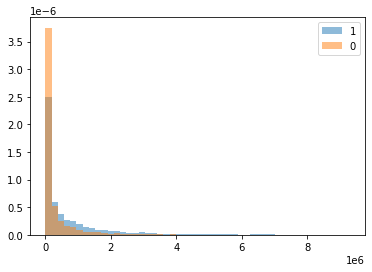

In [33]:
bins = np.linspace(min(df_dropped.total_votes_diff.values), max(df_dropped.total_votes_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].total_votes_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].total_votes_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [34]:
print('total_votes_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].total_votes_diff.values)))
print('total_votes_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].total_votes_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].total_votes_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].total_votes_diff.values, 
                      equal_var=False)

total_votes_diff variance in pairs w/ collab is  1614598418040.543
total_votes_diff variance in pairs w/o collab is  527109690822.2613


Ttest_indResult(statistic=28.404723742823816, pvalue=4.0248852997916604e-167)

### runtime

In [35]:
actor_total_runtime = {}
actor_mean_runtime = {}
add_feature_actor(actor_total_runtime, actor_mean_runtime, 'runtime')
df["actor_total_runtime"] = df.actor.map(actor_total_runtime)
df["actor_mean_runtime"] = df.actor.map(actor_mean_runtime)

director_total_runtime = {}
director_mean_runtime = {}
add_feature_director(director_total_runtime, director_mean_runtime, 'runtime')
df["director_total_runtime"] = df.director.map(director_total_runtime)
df["director_mean_runtime"] = df.director.map(director_mean_runtime)

df["total_runtime_diff"] = abs(df.director_total_runtime - df.actor_total_runtime)
df["mean_runtime_diff"] = abs(df.director_mean_runtime - df.actor_mean_runtime)
df.head()

,director,actor,collabs,collab indicator,actor_total_budget,actor_mean_budget,director_total_budget,director_mean_budget,total_budget_diff,mean_budget_diff,...,director_total_votes,director_mean_votes,total_votes_diff,mean_votes_diff,actor_total_runtime,actor_mean_runtime,director_total_runtime,director_mean_runtime,total_runtime_diff,mean_runtime_diff
0,Joel Edgerton,Andrew Robinson,0,0,1000000.0,1.000000e+06,5000000.0,5000000.0,4000000.0,4.000000e+06,...,103554,103554.0,20345,20345.0,94,94.000000,108,108.0,14,14.000000
1,Joel Edgerton,Miles Teller,0,0,144800000.0,2.413333e+07,5000000.0,5000000.0,139800000.0,1.913333e+07,...,103554,103554.0,778299,43421.5,598,99.666667,108,108.0,490,8.333333
2,Joel Edgerton,Martin Landau,0,0,44000000.0,2.200000e+07,5000000.0,5000000.0,39000000.0,1.700000e+07,...,103554,103554.0,52877,78215.5,194,97.000000,108,108.0,86,11.000000
3,Joel Edgerton,Christopher McDonald,0,0,15000000.0,1.500000e+07,5000000.0,5000000.0,10000000.0,1.000000e+07,...,103554,103554.0,100158,100158.0,84,84.000000,108,108.0,24,24.000000
4,Joel Edgerton,Wagner Moura,0,0,4000000.0,2.000000e+06,5000000.0,5000000.0,1000000.0,3.000000e+06,...,103554,103554.0,53918,24818.0,230,115.000000,108,108.0,122,7.000000


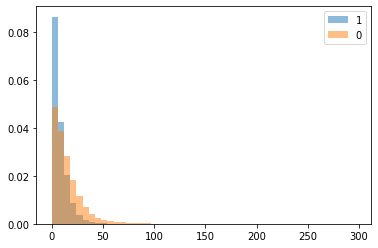

In [36]:
df_dropped = df.copy().dropna()
bins = np.linspace(min(df_dropped.mean_runtime_diff.values), max(df_dropped.mean_runtime_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].mean_runtime_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].mean_runtime_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [37]:
print('mean_runtime_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].mean_runtime_diff.values)))
print('mean_runtime_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].mean_runtime_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].mean_runtime_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].mean_runtime_diff.values, 
                      equal_var=False)

mean_runtime_diff variance in pairs w/ collab is  67.40045405463802
mean_runtime_diff variance in pairs w/o collab is  277.32938658175084


Ttest_indResult(statistic=-73.4969690979844, pvalue=0.0)

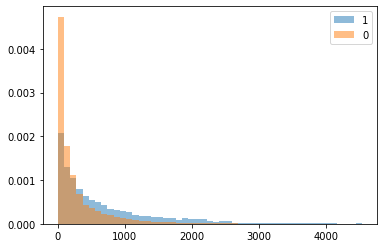

In [38]:
bins = np.linspace(min(df_dropped.total_runtime_diff.values), max(df_dropped.total_runtime_diff.values), 50)
plt.hist(df_dropped[df_dropped["collab indicator"] == 1].total_runtime_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_dropped[df_dropped["collab indicator"] == 0].total_runtime_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [39]:
print('total_runtime_diff variance in pairs w/ collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 1].total_runtime_diff.values)))
print('total_runtime_diff variance in pairs w/o collab is  {}'.format(np.var(df_dropped[df_dropped["collab indicator"] == 0].total_runtime_diff.values)))
ttest_ind(df_dropped[df_dropped["collab indicator"] == 1].total_runtime_diff.values, 
                      df_dropped[df_dropped["collab indicator"] == 0].total_runtime_diff.values, 
                      equal_var=False)

total_runtime_diff variance in pairs w/ collab is  595748.240071503
total_runtime_diff variance in pairs w/o collab is  216318.20321231606


Ttest_indResult(statistic=39.887490193490606, pvalue=0.0)

### oscar nomination

In [84]:
oscar = pd.read_csv("../data/the_oscar_award.csv")
oscar.head()

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False


In [85]:
oscar.category = oscar.category.str.lower()
filtered = oscar[oscar.category.str.contains("(actor)|(actress)|(directing)", regex = True)]
filtered

/opt/miniconda3/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,actor,Richard Barthelmess,The Noose,False
1,1927,1928,1,actor,Emil Jannings,The Last Command,True
2,1927,1928,1,actress,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,actress,Janet Gaynor,7th Heaven,True
4,1927,1928,1,actress,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10302,2019,2020,92,directing,Martin Scorsese,The Irishman,False
10303,2019,2020,92,directing,Todd Phillips,Joker,False
10304,2019,2020,92,directing,Sam Mendes,1917,False
10305,2019,2020,92,directing,Quentin Tarantino,Once upon a Time...in Hollywood,False


In [86]:
filtered.loc[filtered.category.str.contains("(actor)|(actress)"), 'is_director'] = 0
filtered.loc[filtered.category.str.contains("directing"), 'is_director'] = 1

/opt/miniconda3/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [87]:
oscar_ppl = filtered[~filtered.name.str.contains("( and)|(,)|(and )", regex = True)]
oscar_ppl.is_director = oscar_ppl.is_director.astype(np.uint8)
oscar_ppl.head()


/opt/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,year_film,year_ceremony,ceremony,category,name,film,winner,is_director
0,1927,1928,1,actor,Richard Barthelmess,The Noose,False,0
1,1927,1928,1,actor,Emil Jannings,The Last Command,True,0
2,1927,1928,1,actress,Louise Dresser,A Ship Comes In,False,0
3,1927,1928,1,actress,Janet Gaynor,7th Heaven,True,0
4,1927,1928,1,actress,Gloria Swanson,Sadie Thompson,False,0


In [88]:
gp_ppl = oscar_ppl.groupby(['name', 'is_director']).size().reset_index(name='nomination_counts')
gp_ppl_director = gp_ppl.groupby(['is_director']).get_group(1)
gp_ppl_actor = gp_ppl.groupby(['is_director']).get_group(0)
gp_ppl_director.head()

,name,is_director,nomination_counts
2,Adam McKay,1,2
5,Adrian Lyne,1,1
10,Akira Kurosawa,1,1
15,Alan J. Pakula,1,1
16,Alan Parker,1,2


In [89]:
gp_ppl_actor.head()

,name,is_director,nomination_counts
0,Abigail Breslin,0,1
1,Adam Driver,0,2
3,Adolph Caesar,0,1
4,Adolphe Menjou,0,1
6,Adriana Barraza,0,1


In [91]:
df_w_oscar= pd.merge(df, gp_ppl_director, left_on='director', right_on='name')
df_w_oscar= pd.merge(df_w_oscar, gp_ppl_actor, left_on='actor', right_on='name')
df_w_oscar.drop(['name_x', 'is_director_x', 'name_y', 'is_director_y'], axis=1, inplace=True)
df_w_oscar.rename(columns={'nomination_counts_x': 'director_nominations', 'nomination_counts_y': 'actor_nominations'}, inplace=True)
df_w_oscar.head()

,director,actor,collabs,collab indicator,actor_total_budget,actor_mean_budget,director_total_budget,director_mean_budget,total_budget_diff,mean_budget_diff,...,total_votes_diff,mean_votes_diff,actor_total_runtime,actor_mean_runtime,director_total_runtime,director_mean_runtime,total_runtime_diff,mean_runtime_diff,director_nominations,actor_nominations
0,Peter Bogdanovich,Martin Landau,0,0,44000000.0,22000000.0,46000000.0,7.666667e+06,2000000.0,1.433333e+07,...,6146,17916.666667,194,97.0,649,108.166667,455,11.166667,1,3
1,Francis Ford Coppola,Martin Landau,0,0,44000000.0,22000000.0,230000000.0,2.555556e+07,186000000.0,3.555556e+06,...,568111,43415.722222,194,97.0,1113,123.666667,919,26.666667,3,3
2,Spike Lee,Martin Landau,0,0,44000000.0,22000000.0,311175000.0,1.728750e+07,267175000.0,4.712500e+06,...,759537,19673.388889,194,97.0,2345,130.277778,2151,33.277778,1,3
3,Warren Beatty,Martin Landau,0,0,44000000.0,22000000.0,102000000.0,3.400000e+07,58000000.0,1.200000e+07,...,27726,795.833333,194,97.0,340,113.333333,146,16.333333,1,3
4,Richard Rush,Martin Landau,0,0,44000000.0,22000000.0,40000000.0,4.000000e+07,4000000.0,1.800000e+07,...,30842,5503.500000,194,97.0,121,121.000000,73,24.000000,1,3


In [92]:
df_w_oscar['nominations_diff']=df_w_oscar['director_nominations'] - df_w_oscar['actor_nominations']
df_w_oscar.head()

,director,actor,collabs,collab indicator,actor_total_budget,actor_mean_budget,director_total_budget,director_mean_budget,total_budget_diff,mean_budget_diff,...,mean_votes_diff,actor_total_runtime,actor_mean_runtime,director_total_runtime,director_mean_runtime,total_runtime_diff,mean_runtime_diff,director_nominations,actor_nominations,nominations_diff
0,Peter Bogdanovich,Martin Landau,0,0,44000000.0,22000000.0,46000000.0,7.666667e+06,2000000.0,1.433333e+07,...,17916.666667,194,97.0,649,108.166667,455,11.166667,1,3,-2
1,Francis Ford Coppola,Martin Landau,0,0,44000000.0,22000000.0,230000000.0,2.555556e+07,186000000.0,3.555556e+06,...,43415.722222,194,97.0,1113,123.666667,919,26.666667,3,3,0
2,Spike Lee,Martin Landau,0,0,44000000.0,22000000.0,311175000.0,1.728750e+07,267175000.0,4.712500e+06,...,19673.388889,194,97.0,2345,130.277778,2151,33.277778,1,3,-2
3,Warren Beatty,Martin Landau,0,0,44000000.0,22000000.0,102000000.0,3.400000e+07,58000000.0,1.200000e+07,...,795.833333,194,97.0,340,113.333333,146,16.333333,1,3,-2
4,Richard Rush,Martin Landau,0,0,44000000.0,22000000.0,40000000.0,4.000000e+07,4000000.0,1.800000e+07,...,5503.500000,194,97.0,121,121.000000,73,24.000000,1,3,-2


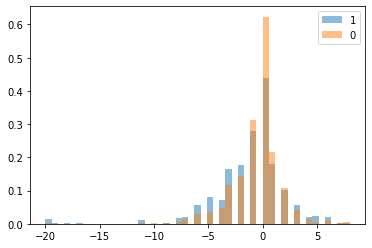

In [93]:
bins = np.linspace(min(df_w_oscar.nominations_diff.values), max(df_w_oscar.nominations_diff.values), 50)
plt.hist(df_w_oscar[df_w_oscar["collab indicator"] == 1].nominations_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df_w_oscar[df_w_oscar["collab indicator"] == 0].nominations_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [94]:
print('nominations_diff variance in pairs w/ collab is  {}'.format(np.var(df_w_oscar[df_w_oscar["collab indicator"] == 1].nominations_diff.values)))
print('nominations_diff variance in pairs w/o collab is  {}'.format(np.var(df_w_oscar[df_w_oscar["collab indicator"] == 0].nominations_diff.values)))
ttest_ind(df_w_oscar[df_w_oscar["collab indicator"] == 1].nominations_diff.values, 
                      df_w_oscar[df_w_oscar["collab indicator"] == 0].nominations_diff.values, 
                      equal_var=False)

nominations_diff variance in pairs w/ collab is  11.675624990825147
nominations_diff variance in pairs w/o collab is  5.747848063463029


Ttest_indResult(statistic=-3.9763645704487445, pvalue=7.977315478395336e-05)